# Bank Churn analysis
Dataset provided at location `data/BankChurners.csv`

# Load data

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [42]:
path = os.path.join('data','BankChurners.csv')
df = pd.read_csv(path)

In [43]:
df.head()

CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0  768805383  Existing Customer            45      M                3   
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   
3  769911858  Existing Customer            40      F                4   
4  709106358  Existing Customer            40      M                3   

  Education_Level Marital_Status Income_Category Card_Category  \
0     High School        Married     $60K - $80K          Blue   
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   
3     High School        Unknown  Less than $40K          Blue   
4      Uneducated        Married     $60K - $80K          Blue   

   Months_on_book  ...  Contacts_Count_12_mon  Credit_Limit  \
0              39  ...                      3       12691.0   
1              44  ...                      2        8256.0   
2              36  ...                      0        3418.0   
3              34  ...                      1        3313.0   
4              21  ...                      0        4716.0   

   Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
0                  777          11914.0                 1.335   
1                  864           7392.0                 1.541   
2                    0           3418.0                 2.594   
3                 2517            796.0                 1.405   
4                    0           4716.0                 2.175   

   Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  \
0             1144              42                1.625   
1             1291              33                3.714   
2             1887              20                2.333   
3             1171              20                2.333   
4              816              28                2.500   

   Avg_Utilization_Ratio  Unnamed: 21  
0                  0.061          NaN  
1                  0.105          NaN  
2                  0.000          NaN  
3                  0.760          NaN  
4                  0.000          NaN  

[5 rows x 22 columns]

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

**Summary of raw data as imported:**
- We have over 10,000 rows, and 21 columns
- Columns:
  - CLIENTNUM probably just an id number, not likely to be informative.
  - Attrition_Flag is the dependent variable we are trying to predict (churn/non-churn etc)
  - Several columns like Gender, Marital status are really `categorical`, rather than `object` type.  Should look at label encoding the unique values.
  - There is an `Unnamed` column with 0 non-null values this can be safely dropped.
  - Lots of informative looking numerical features/columns to do with transaction stats.  Might be able to gain some information by engineering new features as combinations of these.


# Data cleaning
Tidy up data types, drop useless columns, check for nulls etc.

## Lowercase col names
Convert column names to lowercase to avoid mistakes.

In [45]:
df.columns = df.columns.str.lower()

## "unnamed" empty column
Drop the `Unnamed` column

In [46]:
df = df.drop(columns='unnamed: 21')

## attrition_flag (churn)
Replace attrition_flag with a boolean column called "churn" as True/False (for convenience)

In [47]:
df.loc[:,'churn'] = (df['attrition_flag'] == 'Attrited Customer').astype(int)
df = df.drop(columns='attrition_flag')
df.churn.value_counts()

False    8500
True     1627
Name: churn, dtype: int64

## Check for any nulls
If any, then we would need to consider an imputation strategy to deal with these

In [59]:
df.isna().sum()

clientnum                   0
customer_age                0
gender                      0
dependent_count             0
education_level             0
marital_status              0
income_category             0
card_category               0
months_on_book              0
total_relationship_count    0
months_inactive_12_mon      0
contacts_count_12_mon       0
credit_limit                0
total_revolving_bal         0
avg_open_to_buy             0
total_amt_chng_q4_q1        0
total_trans_amt             0
total_trans_ct              0
total_ct_chng_q4_q1         0
avg_utilization_ratio       0
churn                       0
dtype: int64

In this case, there are zero null values.  All columns are populated for all 10,000 customer records so no imputation looks necessary

## Convert to categorical type
Convert to categorical type for efficiency and because ML models can't directly work with objects/strings, so these columns need to become encoded eventually anyway.

In [54]:
df.loc[:,'gender'] = df.gender.astype('category')
df.loc[:,'education_level'] = df.education_level.astype('category')
df.loc[:,'marital_status'] = df.marital_status.astype('category')
df.loc[:,'income_category'] = df.income_category.astype('category')
df.loc[:,'card_category'] = df.card_category.astype('category')

# Exploratory analysis

## Basic statistics

In [91]:
df.describe()

clientnum  customer_age  dependent_count  months_on_book  \
count  1.012700e+04  10127.000000     10127.000000    10127.000000   
mean   7.391776e+08     46.325960         2.346203       35.928409   
std    3.690378e+07      8.016814         1.298908        7.986416   
min    7.080821e+08     26.000000         0.000000       13.000000   
25%    7.130368e+08     41.000000         1.000000       31.000000   
50%    7.179264e+08     46.000000         2.000000       36.000000   
75%    7.731435e+08     52.000000         3.000000       40.000000   
max    8.283431e+08     73.000000         5.000000       56.000000   

       total_relationship_count  months_inactive_12_mon  \
count              10127.000000            10127.000000   
mean                   3.812580                2.341167   
std                    1.554408                1.010622   
min                    1.000000                0.000000   
25%                    3.000000                2.000000   
50%                    4.000000                2.000000   
75%                    5.000000                3.000000   
max                    6.000000                6.000000   

       contacts_count_12_mon  credit_limit  total_revolving_bal  \
count           10127.000000  10127.000000         10127.000000   
mean                2.455317   8631.953698          1162.814061   
std                 1.106225   9088.776650           814.987335   
min                 0.000000   1438.300000             0.000000   
25%                 2.000000   2555.000000           359.000000   
50%                 2.000000   4549.000000          1276.000000   
75%                 3.000000  11067.500000          1784.000000   
max                 6.000000  34516.000000          2517.000000   

       avg_open_to_buy  total_amt_chng_q4_q1  total_trans_amt  total_trans_ct  \
count     10127.000000          10127.000000     10127.000000    10127.000000   
mean       7469.139637              0.759941      4404.086304       64.858695   
std        9090.685324              0.219207      3397.129254       23.472570   
min           3.000000              0.000000       510.000000       10.000000   
25%        1324.500000              0.631000      2155.500000       45.000000   
50%        3474.000000              0.736000      3899.000000       67.000000   
75%        9859.000000              0.859000      4741.000000       81.000000   
max       34516.000000              3.397000     18484.000000      139.000000   

       total_ct_chng_q4_q1  avg_utilization_ratio         churn  
count         10127.000000           10127.000000  10127.000000  
mean              0.712222               0.274894      0.160660  
std               0.238086               0.275691      0.367235  
min               0.000000               0.000000      0.000000  
25%               0.582000               0.023000      0.000000  
50%               0.702000               0.176000      0.000000  
75%               0.818000               0.503000      0.000000  
max               3.714000               0.999000      1.000000

In [94]:
df.describe(include='all')

clientnum  customer_age gender  dependent_count education_level  \
count   1.012700e+04  10127.000000  10127     10127.000000           10127   
unique           NaN           NaN      2              NaN               7   
top              NaN           NaN      F              NaN        Graduate   
freq             NaN           NaN   5358              NaN            3128   
mean    7.391776e+08     46.325960    NaN         2.346203             NaN   
std     3.690378e+07      8.016814    NaN         1.298908             NaN   
min     7.080821e+08     26.000000    NaN         0.000000             NaN   
25%     7.130368e+08     41.000000    NaN         1.000000             NaN   
50%     7.179264e+08     46.000000    NaN         2.000000             NaN   
75%     7.731435e+08     52.000000    NaN         3.000000             NaN   
max     8.283431e+08     73.000000    NaN         5.000000             NaN   

       marital_status income_category card_category  months_on_book  \
count           10127           10127         10127    10127.000000   
unique              4               6             4             NaN   
top           Married  Less than $40K          Blue             NaN   
freq             4687            3561          9436             NaN   
mean              NaN             NaN           NaN       35.928409   
std               NaN             NaN           NaN        7.986416   
min               NaN             NaN           NaN       13.000000   
25%               NaN             NaN           NaN       31.000000   
50%               NaN             NaN           NaN       36.000000   
75%               NaN             NaN           NaN       40.000000   
max               NaN             NaN           NaN       56.000000   

        total_relationship_count  ...  contacts_count_12_mon  credit_limit  \
count               10127.000000  ...           10127.000000  10127.000000   
unique                       NaN  ...                    NaN           NaN   
top                          NaN  ...                    NaN           NaN   
freq                         NaN  ...                    NaN           NaN   
mean                    3.812580  ...               2.455317   8631.953698   
std                     1.554408  ...               1.106225   9088.776650   
min                     1.000000  ...               0.000000   1438.300000   
25%                     3.000000  ...               2.000000   2555.000000   
50%                     4.000000  ...               2.000000   4549.000000   
75%                     5.000000  ...               3.000000  11067.500000   
max                     6.000000  ...               6.000000  34516.000000   

        total_revolving_bal  avg_open_to_buy  total_amt_chng_q4_q1  \
count          10127.000000     10127.000000          10127.000000   
unique                  NaN              NaN                   NaN   
top                     NaN              NaN                   NaN   
freq                    NaN              NaN                   NaN   
mean            1162.814061      7469.139637              0.759941   
std              814.987335      9090.685324              0.219207   
min                0.000000         3.000000              0.000000   
25%              359.000000      1324.500000              0.631000   
50%             1276.000000      3474.000000              0.736000   
75%             1784.000000      9859.000000              0.859000   
max             2517.000000     34516.000000              3.397000   

        total_trans_amt  total_trans_ct  total_ct_chng_q4_q1  \
count      10127.000000    10127.000000         10127.000000   
unique              NaN             NaN                  NaN   
top                 NaN             NaN                  NaN   
freq                NaN             NaN                  NaN   
mean        4404.086304       64.858695             0.712222   
std         3397.129254       23.472570             0.23808

## Scatter matrix

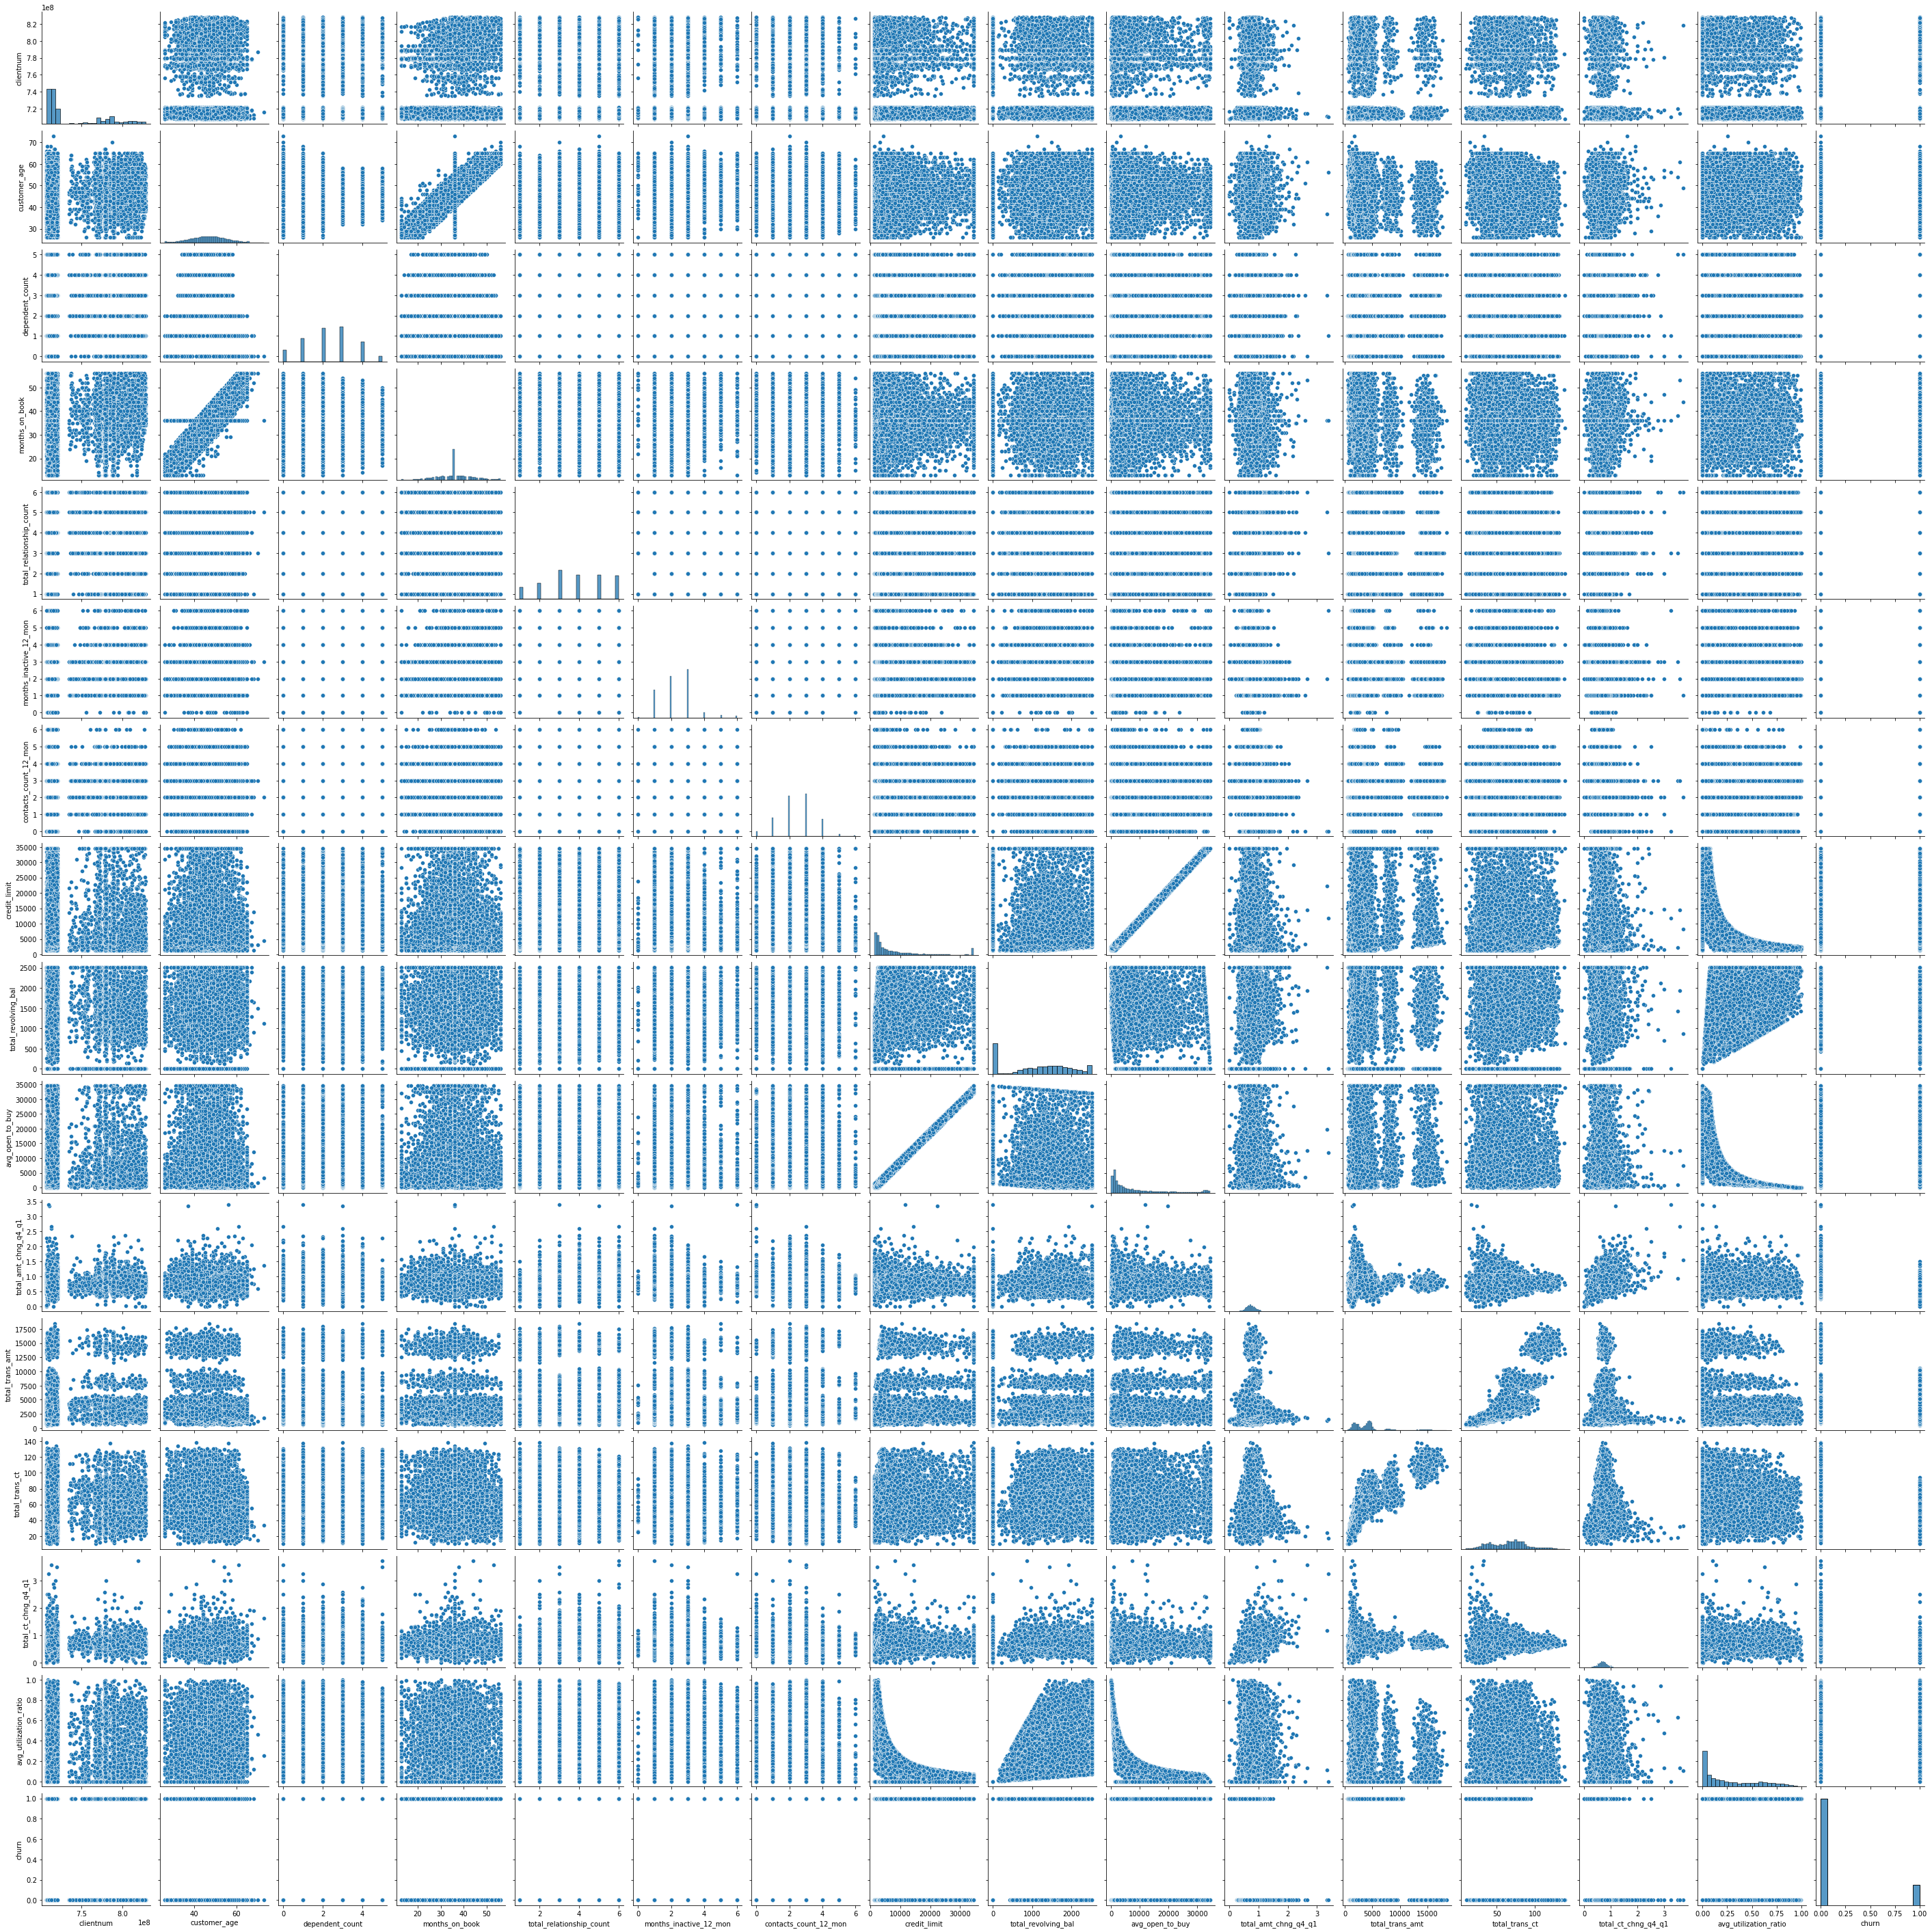

In [89]:
sns.pairplot(df);

Really hard to see much as the matrix of plots is so dense, but zooming in showed the following highlights:
- clientnum has no obvious correlation to any other parameters. No clear influence on churn.  Though there seems to be a large number of small numbers and large numbers for client id, but not so many in between. Interesting, but probably not very informative.
- customer_age looks quite normally distributed, with peak just over 40.
- dependent_count also looks normally distributed, peaking between 2 and 3 dependents.
- months_on_book histogram is poorly scaled but looks normal, with an unusual spike at around 35months. Was there some large promotional drive 30months ago that explains this?
- total_relationship count is reasonably uniform rather than normal, between 

## Correlation matrix
Pearson correlation matrix

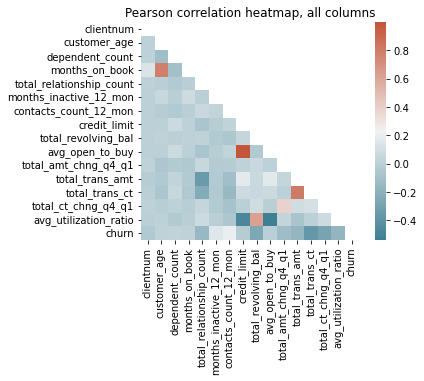

In [77]:
# Plot with mask for triangle plot only
corr_mat = df.corr()
mask = np.triu(corr_mat)
cmap = sns.diverging_palette(220, 20, as_cmap=True)
ax = sns.heatmap(corr_mat, square=True, mask=mask, cmap=cmap);
ax.set_title('Pearson correlation heatmap, all columns');

Summary of correlation matrix:
- 

# Modelling

## Baseline model
